In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-10-08 
Git hash: c5425d3c436714fc2475c8e5525cbd28738fd3eb


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
complete_srx = store['aln/complete'].srx.unique().tolist()

In [5]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

## Pull Out Library Strategy

In [6]:
libstrat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': complete_srx},
        }
    },
    {
        '$unwind': {
            'path': "$runs"
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
]))).set_index(['srx', 'srr'])

libstrat_srx = libstrat.reset_index().groupby('srx').first().library_strategy

In [7]:
vcnts = libstrat_srx.value_counts()
vcnts

RNA-Seq                   14423
EST                        4546
ChIP-Seq                   3003
OTHER                      2572
WGS                        1972
miRNA-Seq                   131
MNase-Seq                   116
Targeted-Capture             96
AMPLICON                     86
ncRNA-Seq                    69
RIP-Seq                      58
FAIRE-seq                    19
DNase-Hypersensitivity       10
POOLCLONE                     8
FL-cDNA                       7
CLONEEND                      7
MeDIP-Seq                     6
WGA                           6
Bisulfite-Seq                 5
CLONE                         1
Name: library_strategy, dtype: int64

In [8]:
drop_label = vcnts.index[vcnts < 50].tolist()

In [9]:
# Change everything with fewer than 50 samples to OTHER, the classifiers don't work well with too few samples
for label in drop_label:
    libstrat_srx[libstrat_srx == label] = 'OTHER'

In [10]:
srrs = libstrat.index.get_level_values('srr')
srxs = libstrat_srx.index

## Build Feature Table

In [11]:
# collect RNA-seq metrics
cols = [
    'PCT_CODING_BASES',
    'PCT_UTR_BASES',
    'PCT_INTRONIC_BASES',
    'PCT_INTERGENIC_BASES',
    'PCT_MRNA_BASES',
    'MEDIAN_CV_COVERAGE',
    'MEDIAN_5PRIME_BIAS',
    'MEDIAN_3PRIME_BIAS'
]

cm = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', where='srx == srxs', columns=cols)

# collect RNA-seq metrics gene body coverage
gb = store.select('prealn/workflow/collectrnaseqmetrics/genebody', where='srx == srxs')

# markduplicates
cols = [
    'PERCENT_DUPLICATION',
]

mark = store.select('prealn/workflow/markduplicates', where='srx == srxs', columns=cols)

# feature counts summary
cols = [
    'Assigned',
    'Unassigned_Ambiguity',
    'Unassigned_MultiMapping',
    'Unassigned_NoFeatures',
    'Unassigned_Unmapped'
]

feature_summary = store.select('prealn/workflow/feature_counts/summary', columns=cols, where='srx == srxs')

# Munge together
dat_by_srr = cm.join(gb).join(mark).join(feature_summary)
dat_by_srr_no_na = dat_by_srr.fillna(dat_by_srr.mean().to_dict(), axis=0)
dat_by_srr_no_na.shape

# Coverage counts
genic = pd.read_parquet('../output/aln-downstream-wf/aggregate_genic_counts.parquet').reindex(srxs)['count']
genic.name = 'genic'
genic = genic.astype(np.float64)

intergenic = pd.read_parquet('../output/aln-downstream-wf/aggregate_intergenic_counts.parquet').reindex(srxs)['count']
intergenic.name = 'intergenic'
intergenic = intergenic.astype(np.float64)

junctions = pd.read_parquet('../output/aln-downstream-wf/aggregate_junction_counts.parquet').reindex(srxs)['count']
junctions.name = 'junctions'
junctions = junctions.astype(np.float64)

coverage = pd.concat([genic, intergenic, junctions], axis=1)

# Make feature set with all features
features = dat_by_srr_no_na.reset_index().groupby('srx').mean().join(coverage)

In [12]:
# Only look at things we have features for
Y = libstrat_srx.reindex(features.index)

# split out the OTHER category
Y_OTHER = Y[Y == 'OTHER'].copy()
features_OTHER = features.reindex(Y_OTHER.index).dropna()

Y = Y[Y != 'OTHER'].copy()
features = features.reindex(Y.index)

In [13]:
# Encode labels
encoder = LabelEncoder()
Y_enc = encoder.fit_transform(Y)

X = features.values

## Random Forest Classifier

First I want to construct a random forest classifier that is trained on a subset of the data and can classify samples. I then look for instances where a sample appears to be mis classified.

There is a small problem with train_test_split, because of differences in class size there are some classes that are missing from the training set. This throws an error when calling precision.

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, stratify=Y_enc, random_state=42)

In [15]:
clf =  RandomForestClassifier(n_estimators=200, oob_score=True)

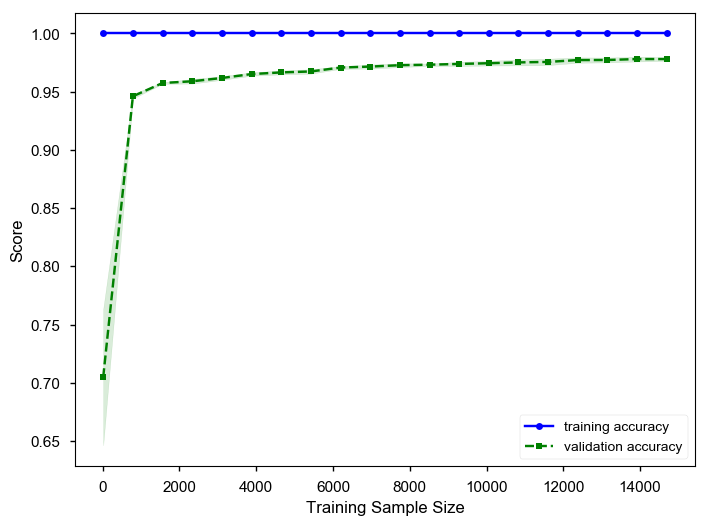

In [16]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, 
    X_train, 
    Y_train, 
    cv=5, 
    train_sizes=np.linspace(0.001, 1, 20), 
    n_jobs=-1, 
)

# Calculate mean scores and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Training Sample Size')
plt.ylabel('Score')
plt.legend(loc='lower right')

In [17]:
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(clf.oob_score_)
print(classification_report(Y_test, Y_pred, target_names=encoder.classes_))

0.979428571429
                  precision    recall  f1-score   support

        AMPLICON       1.00      1.00      1.00        21
        ChIP-Seq       0.94      0.98      0.96       751
             EST       1.00      0.96      0.98      1136
       MNase-Seq       1.00      0.52      0.68        29
         RIP-Seq       1.00      0.40      0.57        15
         RNA-Seq       0.98      1.00      0.99      3606
Targeted-Capture       0.96      0.96      0.96        24
             WGS       0.97      0.94      0.95       493
       miRNA-Seq       1.00      0.76      0.86        33
       ncRNA-Seq       1.00      0.24      0.38        17

       micro avg       0.98      0.98      0.98      6125
       macro avg       0.99      0.77      0.83      6125
    weighted avg       0.98      0.98      0.97      6125



In [18]:
pd.Series(clf.feature_importances_, index=features.columns).sort_values(ascending=False)

PCT_UTR_BASES              0.074579
PCT_INTRONIC_BASES         0.055856
PCT_MRNA_BASES             0.053605
intergenic                 0.050134
pos_0                      0.047277
Unassigned_NoFeatures      0.046017
Unassigned_MultiMapping    0.039708
PCT_INTERGENIC_BASES       0.039460
PCT_CODING_BASES           0.039444
pos_1                      0.032093
MEDIAN_CV_COVERAGE         0.028325
genic                      0.021625
pos_99                     0.021228
PERCENT_DUPLICATION        0.019245
pos_100                    0.018392
Assigned                   0.017312
pos_3                      0.015588
pos_2                      0.014434
MEDIAN_5PRIME_BIAS         0.014378
pos_98                     0.014083
pos_71                     0.014079
Unassigned_Unmapped        0.013769
pos_97                     0.013662
junctions                  0.013130
Unassigned_Ambiguity       0.012110
pos_93                     0.011160
pos_4                      0.010395
pos_96                     0

In [42]:
n = 20

Y_res = np.empty((Y_enc.shape[0], n), dtype=object)
Y_res_other = np.empty((Y_enc.shape[0], n), dtype=object)
for i in range(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, stratify=Y_enc, test_size=.8)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X)
    Y_res[:, i] = encoder.inverse_transform(Y_pred)
    
    Y_pred2 = clf.predict(features_OTHER.values)
    Y_res_other[:, i] = encoder.inverse_transform(Y_pred2)

YPred = pd.DataFrame(Y_res, index=features.index)
YPredOther = pd.DataFrame(Y_res_res, index=features_OTHER.index)

In [61]:
us = YPred.reset_index().melt(id_vars='srx').groupby('srx').value.value_counts().unstack()

In [62]:
us.idxmax(axis=1)

srx
DRX000998     ChIP-Seq
DRX000999     ChIP-Seq
DRX001000     ChIP-Seq
DRX001001     ChIP-Seq
DRX012753      RNA-Seq
DRX012754      RNA-Seq
DRX012755      RNA-Seq
DRX013093      RNA-Seq
DRX013094      RNA-Seq
DRX014765      RNA-Seq
DRX014766      RNA-Seq
DRX014767      RNA-Seq
DRX014768      RNA-Seq
DRX014769      RNA-Seq
DRX014770      RNA-Seq
DRX014771      RNA-Seq
DRX014772      RNA-Seq
DRX014773      RNA-Seq
DRX014774      RNA-Seq
DRX014775      RNA-Seq
DRX014776      RNA-Seq
DRX014777      RNA-Seq
DRX014778      RNA-Seq
DRX014779      RNA-Seq
DRX014780      RNA-Seq
DRX014781      RNA-Seq
DRX014782      RNA-Seq
DRX014783      RNA-Seq
DRX014784      RNA-Seq
DRX014785      RNA-Seq
               ...    
SRX984892    ncRNA-Seq
SRX986397      RNA-Seq
SRX986398      RNA-Seq
SRX986399      RNA-Seq
SRX986400      RNA-Seq
SRX986401      RNA-Seq
SRX986402      RNA-Seq
SRX986403      RNA-Seq
SRX986404      RNA-Seq
SRX986405      RNA-Seq
SRX986406      RNA-Seq
SRX986407      RNA-Seq
SRX9864

In [88]:
# Samples that are always called the same
singles = us[(us == 20).any(axis=1)].index.tolist()
print(len(singles))
us.reindex(singles).stack().to_frame().reset_index().value.value_counts()

23110


RNA-Seq             14321
EST                  4179
ChIP-Seq             2734
WGS                  1690
AMPLICON               80
Targeted-Capture       69
miRNA-Seq              31
ncRNA-Seq               5
MNase-Seq               1
Name: value, dtype: int64

In [71]:
# not called the same every time
multi = us[~(us == 20).any(axis=1)]

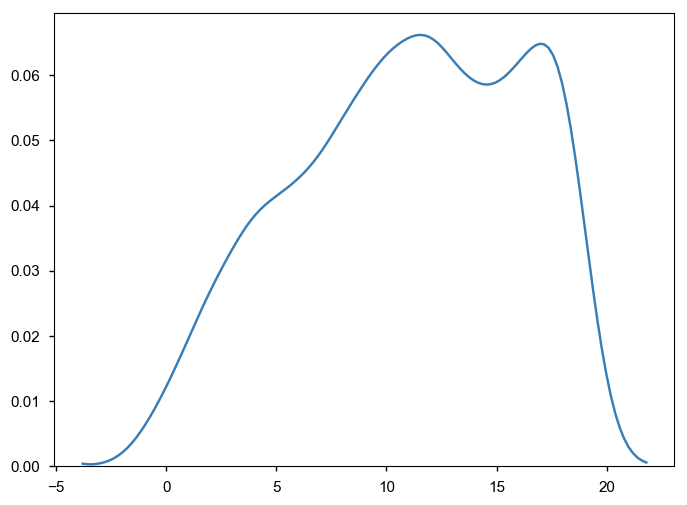

In [76]:
# distribution of difference between most and least called classes
sns.kdeplot(multi.max(axis=1) - multi.min(axis=1))

In [101]:
# will just use the best call if 15 calls went to one
commons = us[(us.max(axis=1) >= 15)].index.tolist()

In [102]:
# These are the problem children
problems = us[~us.index.isin(commons + singles)]

In [115]:
sns.kde

srx         value    
ERX1080662  RNA-Seq       8.0
            miRNA-Seq    12.0
ERX1080670  RNA-Seq      11.0
            miRNA-Seq     9.0
ERX2172904  RNA-Seq      10.0
            miRNA-Seq    10.0
ERX2172905  RNA-Seq       8.0
            miRNA-Seq    12.0
ERX2172906  RNA-Seq      14.0
            miRNA-Seq     6.0
ERX2173751  RNA-Seq       6.0
            miRNA-Seq    14.0
ERX2173764  RNA-Seq       6.0
            miRNA-Seq    14.0
ERX2173935  RNA-Seq       8.0
            miRNA-Seq    12.0
ERX2173942  RNA-Seq       6.0
            miRNA-Seq    14.0
ERX2173944  RNA-Seq       7.0
            miRNA-Seq    13.0
ERX2372811  ChIP-Seq     13.0
            RNA-Seq       7.0
ERX278732   EST          14.0
            RNA-Seq       6.0
ERX965964   RNA-Seq       6.0
            miRNA-Seq    14.0
ERX965965   RNA-Seq       6.0
            miRNA-Seq    14.0
ERX965967   RNA-Seq       9.0
            miRNA-Seq    11.0
                         ... 
SRX893380   WGS           9.0
SRX893381   MNase-

In [112]:
plt.hist?

Signature: plt.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*. The return value is a
tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
[*patches0*, *patches1*,...]) if the input contains multiple
data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
    Input values, this takes either a single array or a sequence of
    arrays which are not required to be of the same length

bins : integer or sequence or 'auto', 

In [71]:
# not called the same every time
multi = us[~(us == 20).any(axis=1)]

In [73]:
multi.shape

(1390, 10)

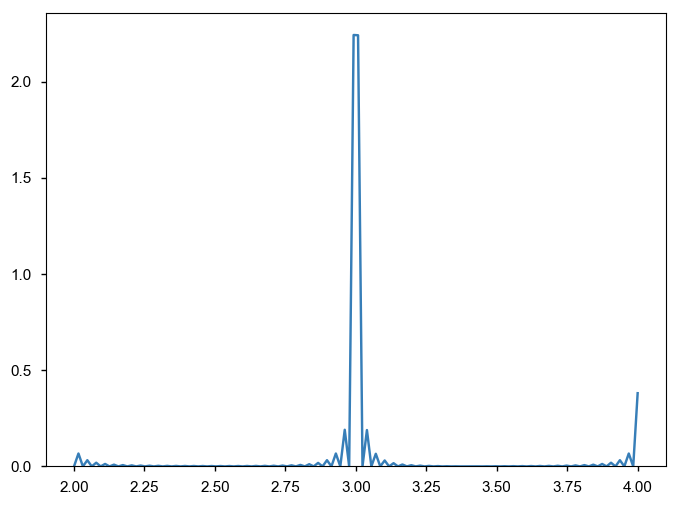

In [82]:
# Distribution of the number of classes
sns.kdeplot((~multi.isna()).sum(axis=1))